# The Northwind Database: Student Project 2

Northwind Traders Access database is a sample database that was created by Microsoft. The database houses sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. 

We will be asking a few questions throughout the analysis and each one will be addressed using hypothesis testing.

Below you can see the schema for the database.  The Schema provided below has some typos in it so some of our code will be slightly different than what is listed in the map
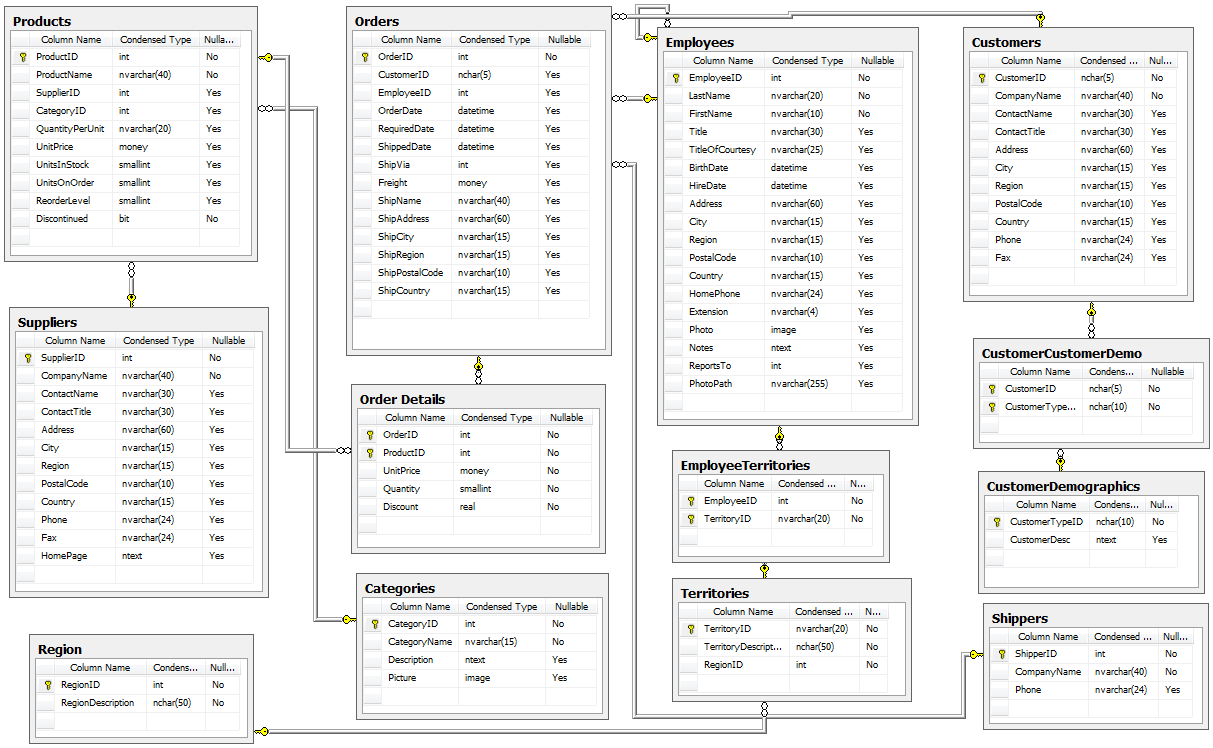

We'll start with importing the necessary libraries.

In [1]:

import sqlite3 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats 
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore') #keeping our notebook clean by ignoring the matplot warnings

In [2]:
# Creating a connection and a cursor object for the database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
tables

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

Creating a loop to put each table into a dataframe so we can operate on the full data set in pandas.

In [4]:
# inititating an empty list and iterating through each table in the table list and the database
#then converting it to a dataframe
data_list = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # turning a string into variable name
    stringize = i+"_df"
    exec(stringize + " = df") # making the name of each dataframe match the database so that: TableName_df
    #adding the tables names to a list
    data_list.append(stringize)

In [5]:
#looking at the list and a the 'Order_df' dataframe head to make sure everything worked
print(data_list)
Order_df.head()

['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [6]:
Order_df.describe()

,Id,EmployeeId,ShipVia,Freight
count,830.000000,830.000000,830.000000,830.000000
mean,10662.500000,4.403614,2.007229,78.244205
std,239.744656,2.499648,0.779685,116.779294
min,10248.000000,1.000000,1.000000,0.020000
25%,10455.250000,2.000000,1.000000,13.380000
50%,10662.500000,4.000000,2.000000,41.360000
75%,10869.750000,7.000000,3.000000,91.430000
max,11077.000000,9.000000,3.000000,1007.640000


The loop functioned and the dataframes appear to have loaded properly.  Now we begin to explore the data and get a feel for whether the first question we asked is a reasonable one.

In [7]:
Product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


For each of the 77 products I want to see if the average quantity ordered is higher with a discount.  

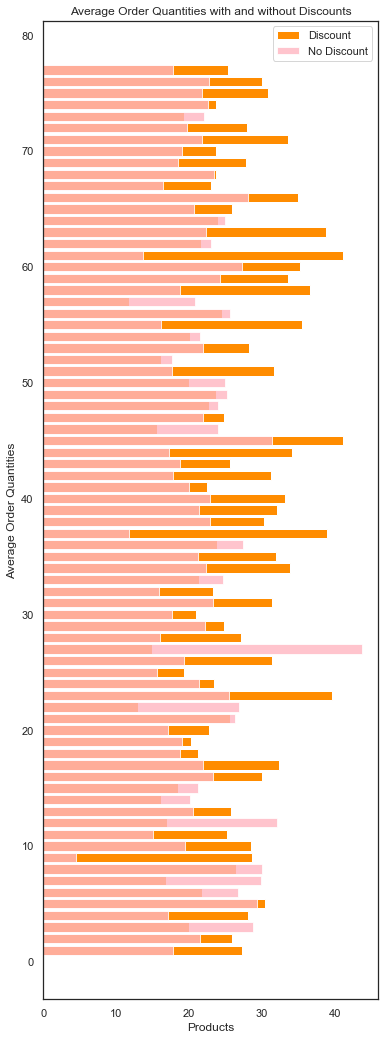

In [8]:
#setting the styling of our plots
sns.set(style = 'white', palette = 'bright')

#creating two line plots showing the average quantity with a discount and without a discount
disc = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_disc = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(6,18))
plt.barh(disc.index, disc.values, alpha=1, label='Discount', color = 'darkorange')
plt.barh(no_disc.index, no_disc.values, alpha=0.8, label='No Discount', color = 'lightpink')
plt.legend()



plt.title('Average Order Quantities with and without Discounts')
plt.xlabel('Products')
plt.ylabel('Average Order Quantities')
plt.show()


In [9]:
print('The Mean Order Size with a discount is ', round(np.array([disc]).mean(),3))
print('The Mean Order Size without a discount is ', round(np.array([no_disc]).mean(),3))

The Mean Order Size with a discount is  26.433
The Mean Order Size without a discount is  21.812


It looks like my initial hypothesis (that discounts $do$ matter) is supported by the above.  But what discount level matters the most?  We can sort our dataframe by discount and explore further.

In [10]:
#Showing each discount level
disc_lvl = OrderDetail_df['Discount'].unique()
disc_lvl.sort()
print('Discount levels :')
print(disc_lvl)

Discount levels :
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


We can now take our dataframe (OrderDetails_df) and group everything by discount amount.


In [11]:
discounts_df = OrderDetail_df.groupby('Discount').count()

In [12]:
discounts_df

,Id,OrderId,ProductId,UnitPrice,Quantity
Discount,,,,,
0.00,1317,1317,1317,1317,1317
0.01,1,1,1,1,1
0.02,2,2,2,2,2
0.03,3,3,3,3,3
0.04,1,1,1,1,1
0.05,185,185,185,185,185
0.06,1,1,1,1,1
0.10,173,173,173,173,173
0.15,157,157,157,157,157


The Next piece of information I want to review is the average order size for each discount level.  Once I have that created as a dictionary we should be able to add the dictionary as a column/series into the dataframe.

In [13]:
#making an empty dictionary
Avg = {}

#Running a loop on the empty dictionary to get the average size by discount level

for i in disc_lvl:
    xi = OrderDetail_df.loc[OrderDetail_df['Discount'] == i]
    Avg[i] = [xi['Quantity'].mean(),xi['Quantity'].count()]

#Always check to ensure everything worked so future steps are clean
Avg


{0.0: [21.715261958997722, 1317],
 0.01: [2.0, 1],
 0.02: [2.0, 2],
 0.03: [1.6666666666666667, 3],
 0.04: [1.0, 1],
 0.05: [28.01081081081081, 185],
 0.06: [2.0, 1],
 0.1: [25.23699421965318, 173],
 0.15: [28.38216560509554, 157],
 0.2: [27.024844720496894, 161],
 0.25: [28.24025974025974, 154]}

In [14]:
#setting up our new dataframe with the information we put into the Avg dictionary
    
disc_df = pd.DataFrame(Avg)
disc_df = disc_df.transpose()

#resetting the index to get Discounts as a column
disc_df.reset_index(inplace = True)

In [15]:
#renaming the columns 
disc_df.rename(index=str, columns={'index':'Discount', 0: "AvgQuantity", 1: "OrderCount"}, inplace = True)

#displaying our new dataframe
disc_df

,Discount,AvgQuantity,OrderCount
0,0.00,21.715262,1317.0
1,0.01,2.000000,1.0
2,0.02,2.000000,2.0
3,0.03,1.666667,3.0
4,0.04,1.000000,1.0
5,0.05,28.010811,185.0
6,0.06,2.000000,1.0
7,0.10,25.236994,173.0
8,0.15,28.382166,157.0
9,0.20,27.024845,161.0


We now have a new dataframe with only the summary of data that is needed to complete the initial hypothesis tests.  The small number of orders for a 1-4%, and 6% discount might cause some trouble given the type of testing we are performing.  I chose to remove them from the dataframe completely as it is only 0.4% of the whole dataset and move forward.

In [16]:
#dropping those rows
disc_df = disc_df.drop(disc_df.index[[1,2,3,4,6]])
disc_df

,Discount,AvgQuantity,OrderCount
0,0.00,21.715262,1317.0
5,0.05,28.010811,185.0
7,0.10,25.236994,173.0
8,0.15,28.382166,157.0
9,0.20,27.024845,161.0
10,0.25,28.240260,154.0


Now I will begin to answer the questions and complete testing. Unless otherwise stated, all tests will be done at a 5% alpha level.

In order to be more efficient I wrote a few formulas to speed up the process that follows. 

## Formulas:

### Cohen's d

The First formula is for Cohen's d, which is an effect size used to indicate the standardised difference between two means.  It helps to define the practicality of the significance and is widely used as an accompaniment to an ANOVA test.  It is also a popular tool to conduct meta-analysis between studies.

In [18]:
def Cohen_d(grp1, grp2):
    # grp1: Dataframe Series or NumPy array
    # grp2: Datafrae Series or NumPy array
    
    #absolute difference between means
    diff = grp1.mean() - grp2.mean()
    
    #sample size and variance of each group
    n1, n2 = len(grp1), len(grp2)
    var1 = grp1.var()
    var2 = grp2.var()

    # pooled threshold - our standardization factor
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    # returns the absolute value of a floating point number 
    return abs(d)

### Visualization

The second formula is for graphing to quickly plot the findings. 


In [19]:
def visualization(control, test):
    plt.figure(figsize=(10,8))
    sns.distplot(test, bins=25,  label='Test')
    sns.distplot(control, bins=25,  label='Control')

    plt.axvline(x=control.mean(), color='darkorange', linestyle='--')
    plt.axvline(x=test.mean(), color='darkblue', linestyle='--')

    plt.title('Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### The first set of null and alternative hypotheses:


### Test 1 - Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

#### Null Hypothesis =  Ho: There is no effect of Discount on the number of products per order.

#### Alternative Hypothesis = Ha: There is a positive effect of having a discount and the number of products per order.

Because there are unequal variances in the two populations (with a discount and without) we can use the Welch's t test to see if they have equal means.  This should answer the first part of the question.  To do this, my method uses the Statsmodels library.

In [20]:
#setting our test group and our control group to create the two populations for the test
control1 = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
test1 = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

P-value:  1.1440924523215966e-10
Reject Null Hypothesis
Cohen's d: 0.2863


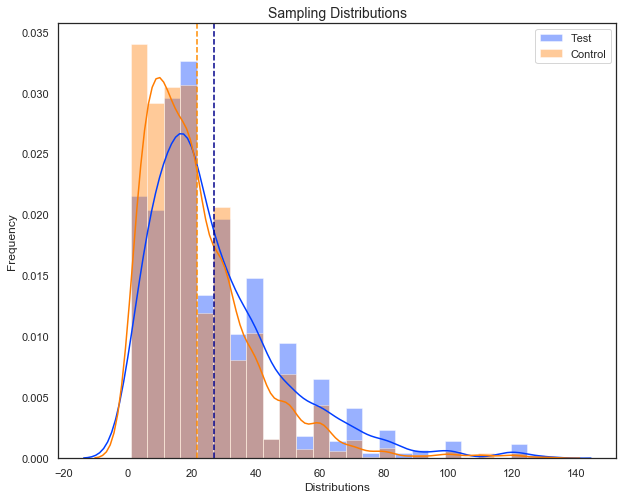

In [21]:
#running the test and using our Cohen's d formula 

t_stat, p = stats.ttest_ind(control1, test1)
Cd = Cohen_d(control1,test1)


#rejecting the null or failing to reject our null based on the above test
#we are using an alpha of 0.05/2 since this is a one tailed test 
print("P-value: ", p)
print('Reject Null Hypothesis') if p < 0.025 else print('Fail to Reject Null Hypothesis')
print("Cohen's d:", round(Cd,4))
visualization(control1, test1)

I rejected the null hypothesis that there is no effect of discounts on the order sizes given that the p-value is less than the alpha.  Therefore I conclude that there is a statistically significant difference in the mean order size of both groups. This is seen quite clearly in the visualization above.

For the second part of the question: at what discount level do we see the statistically significant difference in order quantity.  The general process will be the same but this time I will break everything down into groups by discount.

#### Null Hypothesis = $H_0$: There is no effect of discount on the number of products per order
#### Alternative Hypothesis =  $H_\alpha$: There is a positive effect of having each one of the discounts [5%, 10%, 15%, 20%, 25%] and the number of products per order.

In [22]:
#making a new discount list to only incorporate those levels we kept in our dataframe
discounts = list(disc_df['Discount'])
discounts.pop(0)

#reusing the control variable from above and focus on the test set below
#first creating an empty dataframe with column headers
discounts_significance_df = pd.DataFrame(columns=['Discount','Null Hypothesis','Cohens d'], index=None)

#making a loop to populate the dataframe showing the statistical significance of each discount level 
for i in discounts:
    test = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control1, test)
    d = Cohen_d(test, control1)
    discounts_significance_df = discounts_significance_df.append( {'Discount' : str(i*100)+'%' , 
                                                                   'Null Hypothesis' : 'Reject' if p < 0.025 
                                                                   else 'Fail to Reject', 'Cohens d' : d } , 
                                                                 ignore_index=True)    



,Discount,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


Here, I rejected the null hypothesis in all cases.  There is a statistically significant difference in quantity between products that have a 5%, 10%, 15%, %20, and 25% discount and orders that have no discount at all.

## Let's ask a Second Question: 

### Test 2: Does the average revenue per order vary between regions?

#### Null Hypothesis = $H_0$: the average amount spent per order is the same between different regions.

#### Alternative hypothesis =  $H_\alpha$: the average amount spent per order is different between regions.


This is a two tailed test since I want to know a difference regardless of whether it is higher or lower.

I am running a new SQL query because I want to join more than one table into a single dataframe.

In [23]:
#Writing the SQL statement to pull the info into a single table using two join statments
RegionOrder_df = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', conn)

In [24]:
#Viewing the dataframe
RegionOrder_df.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [25]:
# Calculating the revenue for each product in each order
RegionOrder_df['price_per_order'] = RegionOrder_df.Quantity * RegionOrder_df.UnitPrice * (1 - RegionOrder_df.Discount)

# Dropping the columns for quantity, unit price and discount now that there is a revenue column
RegionOrder_df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Grouping the data by order and summing the revenue for each order
RegionOrder_df = RegionOrder_df.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()

# Dropping the OrderId as this column is no longer needed
RegionOrder_df.drop('OrderId', axis=1, inplace=True)

In [26]:
RegionOrder_df.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [27]:
#Grouping the data by region to see how many orders are from each region
RegionOrder_df.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


For this question I am using ANOVA for the hypothesis testing.  The ANOVA test measures degree of variation between multiple samples.  The sample is each different region.  Because there are some small sample sizes, the data will need to combined for some of the smaller regions.
 

In [28]:
# Combining Eastern Europe and Southern Europe
RegionOrder_df.loc[(RegionOrder_df.Region == 'Eastern Europe') | 
                   (RegionOrder_df.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combining Scandinavia and Northern Europe
RegionOrder_df.loc[(RegionOrder_df.Region == 'Scandinavia') | 
                   (RegionOrder_df.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combining Central America  and South America
RegionOrder_df.loc[(RegionOrder_df.Region == 'Central America') | 
                   (RegionOrder_df.Region == 'South America'),'Region'] = 'South and Central America'

In [52]:
#Reviewing the dataframe to confirm
RegionOrder_df.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


Looking at the summary statistics of the data.

In [30]:
RegionOrder_df.groupby('Region').describe()

price_per_order                            \
                                          count         mean          std   
Region                                                                      
British Isles                              75.0  1452.682867  1618.645044   
North America                             152.0  1945.926977  2209.578928   
Northern Europe and Scandinavia            83.0  1345.799578  1502.782874   
South and Central America                 148.0  1075.918297  1447.262904   
Southern and Eastern Europe                71.0   686.727711   698.164184   
Western Europe                            272.0  1851.280914  2054.829054   

                                                                         \
                                   min        25%        50%        75%   
Region                                                                    
British Isles                    45.00  461.80000   997.0000  1879.8050   
North America                    36.00  533.55000  1260.9375  2411.4375   
Northern Europe and Scandinavia  48.75  486.25000   863.4300  1787.8000   
South and Central America        12.50  369.28125   817.6500  1419.2785   
Southern and Eastern Europe      18.40  157.70000   488.7000   854.6000   
Western Europe                   28.00  575.75000  1319.0975  2150.0500   

                                           
                                      max  
Region                                     
British Isles                    10835.24  
North America                    12615.05  
Northern Europe and Scandinavia  11188.40  
South and Central America        15810.00  
Southern and Eastern Europe       3026.85  
Western Europe                   16387.50

Another ANOVA assumption is that the data is normally distributed. I need to log-transform the data now to arrive at a smoother bell-curve.

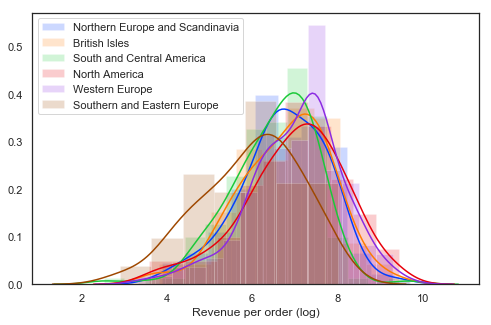

In [31]:
# log-transforming price_per_order into a dataframe copy
RegionOrder_log = RegionOrder_df.copy()
RegionOrder_log['price_per_order'] = np.log(RegionOrder_df['price_per_order'])

# Plotting the distributions for the log-transformed data by region
plt.figure(figsize=(8,5))
for region in set(RegionOrder_log.Region):
    region_group = RegionOrder_log.loc[RegionOrder_log['Region'] == region]
    sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Revenue per order (log)')

In [54]:
# Fitting a model of price_per_order on Regional categories, and running the ANOVA test
lm = ols('price_per_order ~ C(Region)', RegionOrder_log).fit()
tab2 = sm.stats.anova_lm(lm, typ=2)
print(tab2)

               sum_sq     df          F        PR(>F)
C(Region)   77.999547    5.0  13.032374  3.285724e-12
Residual   951.624641  795.0        NaN           NaN


Given this is a two-tailed test,Alpha set to 0.05, and at that level I can reject the null hypothesis. There is a statistically significant difference in the average order revenue between regions.  

Essentially, on average customers from different parts of the world spend differently.


## The Third Question...

### Are the discounts given out at significantly different rates for each employee territory?

There are two groups of employees that work with customers at Northwind, in the US and the UK.  I want to know if  employees in one region or the other are giving out significantly different discounts or if they are the same.  This could be an indication that policy is not being followed as closely or that some additional growth could be present if the level of discount is too low.  

The two-tailed hypotheses follows:

#### Null Hypothesis = $H_0$ : There is no difference in the discounts given by US and UK employees.

#### Alternative Hypothesis = $H_\alpha$ : US and UK employees give significantly different discounts.

I am running another SQL query to pull the data into a single table using join statments.

In [33]:
#running our SQL query and joining orderdetail, and employee tables to the Order table
emp_discount = pd.read_sql_query('''

                    SELECT OD.Discount, E.Country FROM [Order] AS O
                    JOIN OrderDetail AS OD ON O.Id = OD.OrderId
                    JOIN Employee AS E ON O.EmployeeId = E.Id

''', conn)

In [34]:
#reviewing the Dataframe head
emp_discount.head()


,Discount,Country
0,0.0,UK
1,0.0,UK
2,0.0,UK
3,0.0,UK
4,0.0,UK


In [35]:
#looking at  summary statistics
emp_discount.groupby('Country').describe()

Discount                                               
           count      mean       std  min  25%  50%   75%   max
Country                                                        
UK         568.0  0.065493  0.085745  0.0  0.0  0.0  0.15  0.25
USA       1587.0  0.052829  0.082385  0.0  0.0  0.0  0.10  0.25

Just looking at these statistics, one see that there is a difference in the Average discount given for each employee group.  Additionally, the 3rd quartile is a level of discount.  I will add a visualization for further exploration.

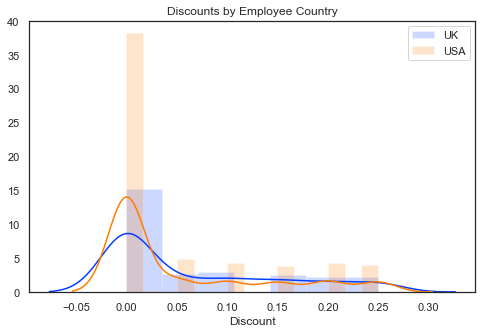

In [36]:
#Plotting data for exploration
plt.figure(figsize=(8,5))
for country in set(emp_discount.Country):
    country_group = emp_discount.loc[emp_discount['Country'] == country]
    sns.distplot(country_group['Discount'], hist_kws=dict(alpha=0.2), label=country)
    plt.legend()
    plt.title('Discounts by Employee Country')

In [38]:
#Running the ANOVA Test
test3 = 'Discount ~ C(Country)'
lm = ols(test3, emp_discount).fit()
tab3 = sm.stats.anova_lm(lm, typ=2)
print(tab3)

               sum_sq      df         F    PR(>F)
C(Country)   0.067081     1.0  9.671415  0.001896
Residual    14.933259  2153.0       NaN       NaN


In [39]:
usa = emp_discount.loc[emp_discount['Country'] == 'USA']
uk = emp_discount.loc[emp_discount['Country'] == 'UK']
Cd3 = Cohen_d(usa,uk)
print("Cohen's d:", round(Cd3,4))

Cohen's d: Discount    0.1521
dtype: float64


The outcome of the test shows that  I can reject the null hypothesis as the p-value is less than the alpha for a two-tailed test.  Therefore, there is a statistically significant difference in discount amount between employees from USA and UK.

While this is significant, the Cohen's d indicated a relatively small effect size.  This indicated that even though the plots above show employees from USA are more likely to give no discount to their clients, the employee location has a small effect on whether the customer receives a discount at all.  

## The Final Question

### Is there a difference in performance from our suppliers?  

For this test I define performance by processing time: the shorter the processing time the better the supplier performance.  In the era of Prime Now, this can be a big factor in decision making for customers.

Two-tailed Hypotheses:

#### Null Hypothesis = $H_0$ : There is no difference in supplier performance.
#### Alternative Hypothesis =  $H_\alpha$ : There is a statistically significant difference in supplier performance.

In [40]:
#Reusing the orders dataframe

#converting dates into a datetime datatype
Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)
Order_df.ShippedDate = pd.to_datetime(Order_df.ShippedDate)
Order_df.RequiredDate = pd.to_datetime(Order_df.RequiredDate)


#calculating the time to process an order and then the time to ship the order
Order_df['ProcessingTime'] = Order_df.ShippedDate - Order_df.OrderDate
Order_df['ShippingTime'] = Order_df.RequiredDate - Order_df.ShippedDate


#standardizing time units to days
Order_df.ShippingTime = Order_df.ShippingTime.dt.days
Order_df.ProcessingTime = Order_df.ProcessingTime.dt.days

In [41]:
#reviwing the  data frame
Order_df.groupby('ShipVia').mean()

,Id,EmployeeId,Freight,ProcessingTime,ShippingTime
ShipVia,,,,,
1,10667.594378,4.232932,65.001325,8.571429,19.485714
2,10674.963190,4.536810,86.640644,9.234921,18.765079
3,10641.592157,4.400000,80.441216,7.473896,19.963855


In [42]:
#Reviewing data to understand what data cleaning is required before testing
Order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 16 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null datetime64[ns]
RequiredDate      830 non-null datetime64[ns]
ShippedDate       809 non-null datetime64[ns]
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
ProcessingTime    809 non-null float64
ShippingTime      809 non-null float64
dtypes: datetime64[ns](3), float64(3), int64(3), object(7)
memory usage: 103.8+ KB


In [43]:
#copying the dataframe and trimming it down to only the columns needed
ship_df = Order_df.copy()
ship_df = ship_df.loc[:,['ShipVia', 'ProcessingTime','ShippingTime']]
ship_df.head()

,ShipVia,ProcessingTime,ShippingTime
0,3,12.0,16.0
1,1,5.0,37.0
2,2,4.0,24.0
3,1,7.0,21.0
4,2,2.0,26.0


In [44]:
ship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 3 columns):
ShipVia           830 non-null int64
ProcessingTime    809 non-null float64
ShippingTime      809 non-null float64
dtypes: float64(2), int64(1)
memory usage: 19.5 KB


In [45]:
#removing null values since they represent such a small portion of the total dataset
ship_df.dropna(inplace=True)
ship_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 3 columns):
ShipVia           809 non-null int64
ProcessingTime    809 non-null float64
ShippingTime      809 non-null float64
dtypes: float64(2), int64(1)
memory usage: 25.3 KB


In [46]:
ship_df.ShipVia.unique()

array([3, 1, 2], dtype=int64)

In [1]:
#plotting the data for exploration 

plt.figure(figsize=(8,5))

#creating each of our distplots
sns.distplot(ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 1], hist_kws=dict(alpha=0.2), label='Shipper 1')
sns.distplot(ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 2], hist_kws=dict(alpha=0.2), label='Shipper 2')
sns.distplot(ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 3], hist_kws=dict(alpha=0.2), label='Shipper 3')

#setting a vertical line at each mean
plt.axvline(x=ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 1].mean(), color='darkblue', linestyle='--')
plt.axvline(x=ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 2].mean(), color='darkorange', linestyle='--')
plt.axvline(x=ship_df['ProcessingTime'].loc[ship_df['ShipVia'] == 3].mean(), color='darkgreen', linestyle='--')


plt.legend()
plt.title('Processing Time by Shipper')

NameError: name 'plt' is not defined

In [49]:
test4= 'ProcessingTime ~ C(ShipVia)'
lm = ols(test4, Order_df).fit()
tab4 = sm.stats.anova_lm(lm, typ=2)
print(tab4)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    433.501581    2.0  4.676819  0.009563
Residual    37354.696194  806.0       NaN       NaN


Based on the p-value being smaller than the alpha, I can reject the null hypothesis.  Each of the shippers performs at different level based on processing times.  

Shipper 3 has the lowest average processing time.  To come to a business conclusion I need additional information about the shipper.  Is this a domestic only Shipper?  Do certain types of international shipments that necessarily come with longer processing times, only go through one shipper?

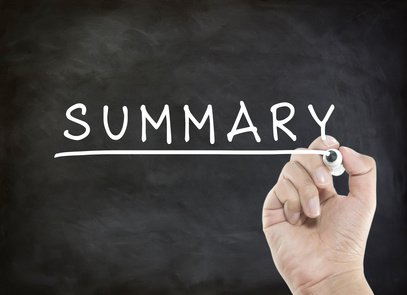

## Business Insights and Conclusion


There is a statistically significant difference in quantity between products that have a 5%, 10%, 15%, %20, and 25% discount and orders that have no discount at all.  Adding discounts incentivizes the customers to buy more of a given product at all discount levels tested.  Customers in each super-region have different spending habits.  Additional growth might be possible by adding focus to regions with a smaller current customer base.  Alternatively, these regions may be eliminated from focus to become more efficient at serving the customers that generate additional revenue.  Management would have to review these strategies against the company goals to make a final decision.   In terms of employee performance, US employees are more likely than UK employees not to give any discount to Northwind's customers.  While the effect of this difference is relatively small, it may be an indication that additional growth may be possible by retraining employees to provide discounts and drive increases in market share.  Finally, Northwind's suppliers perform at varying levels as defined by processing time.  However, as the final test noted, it is important to take the data context into account when forming business recommendations or conclusions. It is not known if these particular suppliers serve different markets and this information would be critical in forming a recommendation for supplier preference. 

## Future Work

If additional time was available to test further, an analysis of both revenue and profit by discount level could be undertaken.  A further review of additional supplier metrics would be tested to provide a more robust recommendation on supplier performance.

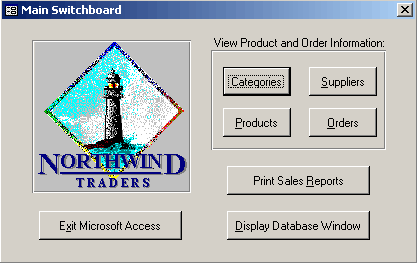

### Process Summary

1. Description of the database and loading the schema photo directly in the notebook

2. Asking our first question so we know what data to load

3. Importing the necessary libaries

4. Creating a connection and cursor for SQLite

5. Converting our SQL tables into DataFrames using a loop

6. Begining our data exploration by plotting the mean of each order size by product both for orders with a discount and for orders without a discount.

7. Plotting average quantity for each order for products for both orders with discoutns and orders without discounts

8. Creating a new dataframe that is indexed by discount and shows the average quantity of the orders at that discoutn level and the total count of orders with each discount level

9. Creating two formulas, one for Cohen's d and one for vusualizations to make the rest of our analysis more efficient

10. Conducting the first half of our hypothesis test using Welch's T and also computing Cohen's d

11. Conducting the second half of our first test using Welch's T and computing Cohen's d

12. Preparing a new datframe for our second test by importing data using SQLite and joinging multiple tables.  

13. Exploring our data and preparing the series for our second hypothesis test, an ANOVA test

14. Log transofrming our target variable, and plotting our distributions

15. Conducting our second hypothesis test using an ANOVA model from Statsmodels

16. Preparing a new datframe for our third test by importing data using SQLite and joinging multiple tables

17. Exploring our data and preparing the series for our second hypothesis test, an ANOVA test

18. Plotting our distributions to review our hypothesis before testing

19. Conducting our third hypothesis test using an ANOVA model from Statsmodels  

20. Computing Cohen's d for our third test to guage the effect size of employee location

21. Using a dataframe that was already created earlier in our notebook to begin our fourth and final test.  

22. Converting the dates in the data frame into datatime objects so we can perform operations on these series

23. Computing two time windows, Processing time and Shipping time so we can guage our supplier performance

24. Reviewing our distribution plots before we perform our ANOVA test

25. Conducting our fourth hypothesis test using an ANOVA model from Statsmodels

26. Summarizing our Business Conclusions and including our furture steps